# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [89]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [90]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")

In [91]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Examining the structure of the general demographics data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [92]:
print("The AZDIAS dataframe has {} n. of rows and {} n. of columns".format(azdias.shape[0], azdias.shape[1]))

The AZDIAS dataframe has 891221 n. of rows and 85 n. of columns


In [93]:
# Getting an overview of the distribution statistics for each feature
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [94]:
# Examining the structure of the feature summary information

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [95]:
print("The Feature Info dataframe has {} n. of rows and {} n. of columns".format(feat_info.shape[0], feat_info.shape[1]))

The Feature Info dataframe has 85 n. of rows and 4 n. of columns


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [96]:
# As a first step we append a column to the feat_info dataframe which has a list of missing values
feat_info["missing_or_unknown_list"] = feat_info["missing_or_unknown"].apply(lambda x: x.replace("[","").replace("]","").split(","))
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [97]:
# We can verify that the new column is indeed a list, whilst the previous one was a string

print(type(feat_info["missing_or_unknown"].iloc[0]))
print(type(feat_info["missing_or_unknown_list"].iloc[0]))

<class 'str'>
<class 'list'>


In [98]:
# Now that we have a list of missing or unknown values we replace every occurrence of such values, for every column, 
# in the azdias dataset

for col in list(azdias.columns):
    for unknown_missing_list in feat_info[feat_info.attribute == col]["missing_or_unknown_list"]:
        if unknown_missing_list != [""]:
            for value in unknown_missing_list:
                try:
                    num_val = float(value)
                    azdias[col] = azdias[col].replace(to_replace={num_val:np.nan})
                except ValueError:
                    azdias[col] = azdias[col].replace(to_replace={value:np.nan})

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [99]:
# Firstly, we create a new Dataframe where every row is a feature, and has two columns
# One representing the number of missing or unknown values, and teh second representing the % with respect to the total n. of values

miss_frame = pd.DataFrame(pd.isnull(azdias).sum(), columns = ["Num. of missing values"])
miss_frame_perc = pd.DataFrame(pd.isnull(azdias).sum() / azdias.shape[0], columns = ["% of missing values"])
miss_frame_complete = pd.concat([miss_frame,miss_frame_perc],axis = 1)

# We investigate the first few rows of this dataframe
miss_frame_complete.head()

,Num. of missing values,% of missing values
AGER_TYP,685843,0.769554
ALTERSKATEGORIE_GROB,2881,0.003233
ANREDE_KZ,0,0.000000
CJT_GESAMTTYP,4854,0.005446
FINANZ_MINIMALIST,0,0.000000


In [100]:
# It is useful at this point to rank these columns 

miss_frame_complete.sort_values(["% of missing values"], ascending=False).head(20)

,Num. of missing values,% of missing values
TITEL_KZ,889061,0.997576
AGER_TYP,685843,0.769554
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
GEBURTSJAHR,392318,0.440203
ALTER_HH,310267,0.348137
KKK,158064,0.177357
REGIOTYP,158064,0.177357
W_KEIT_KIND_HH,147988,0.166051
KBA05_ANTG1,133324,0.149597


In [101]:
# It is also interesting to see at this point what % of the total column number is pure (i.e. no NaN in any observations)

(miss_frame_complete['% of missing values'] > 0).mean()

0.71764705882352942

In [102]:
# We now take a look at some statistics for the distribution of the % of missing values across columns
miss_frame_complete.describe()

,Num. of missing values,% of missing values
count,85.000000,85.000000
mean,98516.811765,0.110541
std,146604.203317,0.164498
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,0.104517
75%,116515.000000,0.130736
max,889061.000000,0.997576


In [103]:
# For the purposes of visualization and statistics calculation with reverse the dataframe
# putting the features in their original position and the two attributes (n. of missing values and % of missinv values as rows)

miss_frame_complete_2 = pd.DataFrame([miss_frame_complete["Num. of missing values"],
                                     miss_frame_complete["% of missing values"]], columns = miss_frame_complete.index, 
                                     index = miss_frame_complete.columns)

miss_frame_complete_2.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
Num. of missing values,685843.000000,2881.000000,0.0,4854.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,116515.000000,116515.000000,116515.000000,116515.000000,116515.000000,116515.000000,116515.000000,97375.00000,97274.000000,97375.00000
% of missing values,0.769554,0.003233,0.0,0.005446,0.0,0.0,0.0,0.0,0.0,0.0,...,0.130736,0.130736,0.130736,0.130736,0.130736,0.130736,0.130736,0.10926,0.109147,0.10926


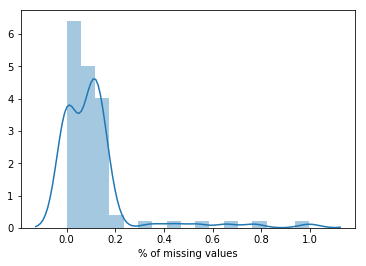

In [104]:
# We can take a look at the distribution of the missing values across columns 

sns.distplot(miss_frame_complete_2.loc["% of missing values",])

In [105]:
# If we look at the chart above we can see visually already what noted in the sorted table
# Most of the columns have a proportion of missing values between 0 and 18%. This will therefore define
# our treshold in removing the same.


# 18% turns out to be between the 92 and 93 quantile of the missing value distribution. 

In [106]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# In order we slice the original dataset (dataframe azdias) via a vector of logicals
threshold_bool = list(miss_frame_complete["% of missing values"] <= 0.18)
azdias_clean = azdias.iloc[:,threshold_bool]
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [107]:
# We confirm we have done the removal process correclty by looking at the shape of the new cleaned dataset

azdias_clean.shape

(891221, 79)

In [108]:
# Printing the list of columns which have been removed in teh process

columns_all = set(list(azdias.columns))
columns_clean = set(list(azdias_clean.columns))

removed = list(columns_all-columns_clean)
print(removed)

['ALTER_HH', 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'KBA05_BAUMAX']


In [109]:
# We take a look now at the remaining features and see which ones are the most problematic ones
# i.e. those with a proportion of missing value not eonugh to be classified as outlier, but still very sizeable

In [110]:
miss_frame_v2 = pd.DataFrame(pd.isnull(azdias_clean).sum(), columns = ["Num. of missing values"])
miss_frame_perc_v2 = pd.DataFrame(pd.isnull(azdias_clean).sum() / azdias_clean.shape[0], columns = ["% of missing values"])
miss_frame_complete_v2 = pd.concat([miss_frame_v2,miss_frame_perc_v2],axis = 1)


In [111]:
miss_frame_complete_v2.sort_values(["% of missing values"], ascending=False).head(20)

,Num. of missing values,% of missing values
KKK,158064,0.177357
REGIOTYP,158064,0.177357
W_KEIT_KIND_HH,147988,0.166051
KBA05_ANTG4,133324,0.149597
KBA05_ANTG1,133324,0.149597
MOBI_REGIO,133324,0.149597
KBA05_GBZ,133324,0.149597
KBA05_ANTG2,133324,0.149597
KBA05_ANTG3,133324,0.149597
PLZ8_GBZ,116515,0.130736


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)


**Answer**

From a first analysis of the dataset there are several columns with a large portion of their values, missing or unknown, encoded here as np.NaN. In summary the % of columns which are pure (totally clean) is ... which is too low compared with the original dataset size to accept the practice of removing any column having even a single missing or unknown value.

Hence we focus a threshold approach, by looking at the rank of columns, by % of missing values. We support this also by a graphical visualization via the seaborn frequency bar plot. We see that the greater density of columns concentrate in the area between 0 and 18% of missing values. We hence decide this (18%) as our threshold and find that the columns to remove are:

- TITEL_KZ : Academic Title
- AGER_TYP : Best-ager typology
- KK_KUNDENTYP : Consumer pattern over the last 12 months
- KBA05_BAUMAX : Most common building type within the microcell
- GEBURTSJAHR : Date of birth
- ALTER_HH : Birthdate of head of household 

If we look at the remaining columns we note that two groups of features account for most of residual missing values. These are:

- KBA05 : Features related to the micro-cell
- PLZ8 : Features related to the macro-cell

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [112]:
# How much data is missing in each row of the dataset?
# We will keep the analysis from the previous dataset with the columns removed (i.e. azdias_clean)

# We can see how many missing values (in % over total number of features) are in each row with the code below
# for ease of visualization just the first rows are shown here
pd.isnull(azdias_clean).mean(axis=1).head(10)

0    0.544304
1    0.000000
2    0.000000
3    0.088608
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
dtype: float64

In [113]:
# As we did for the column we sort the rows in descending order by the number of their missing values
pd.isnull(azdias_clean).mean(axis=1).sort_values(ascending=False).head(10)

643174    0.620253
732775    0.620253
472919    0.607595
183108    0.594937
139316    0.594937
691141    0.594937
691142    0.594937
691171    0.594937
691183    0.594937
139332    0.594937
dtype: float64

In [114]:
# We calculate summary statistics for the distribution of % of missing values in the rows.
pd.isnull(azdias_clean).mean(axis=1).sort_values(ascending=False).describe()

count    891221.000000
mean          0.071518
std           0.167528
min           0.000000
25%           0.000000
50%           0.000000
75%           0.037975
max           0.620253
dtype: float64

In [115]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row. We choose a split threshold based on 30 or more missing values

rows_group_1 = (pd.isnull(azdias_clean).sum(axis=1) <=30)
rows_group_2 = (pd.isnull(azdias_clean).sum(axis=1) >30)

# Once we have the sequence of logicals representing the two groups we subset the dataset accordingly:

azdias_clean_group_1 = azdias_clean.loc[rows_group_1,:]
azdias_clean_group_2 = azdias_clean.loc[rows_group_2,:]

In [116]:
# A quick check that the two slices of our data match our expectations (i.e. gorup 1 should have approx 75+% of observations)

print("Group 1 has {0} of observations".format(round(azdias_clean_group_1.shape[0] / azdias_clean.shape[0], 2)))
print("Group 2 has {0} of observations".format(round(azdias_clean_group_2.shape[0] / azdias_clean.shape[0], 2)))

Group 1 has 0.9 of observations
Group 2 has 0.1 of observations


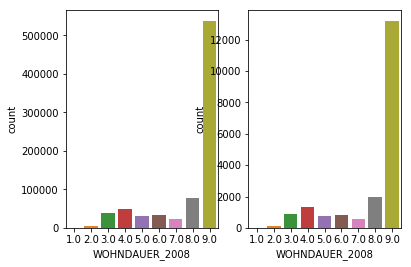

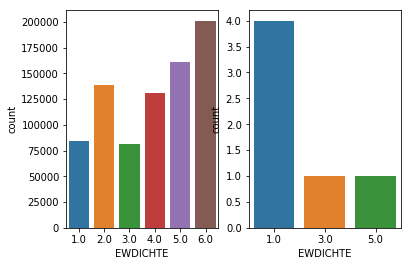

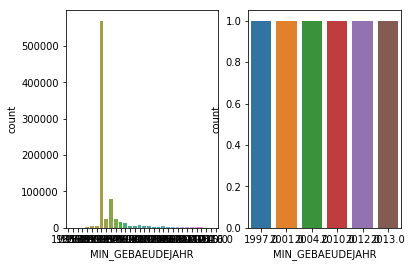

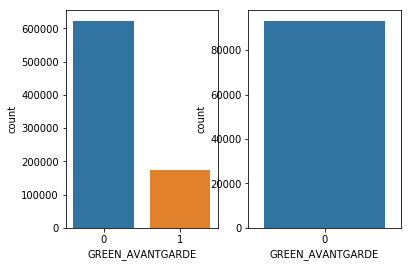

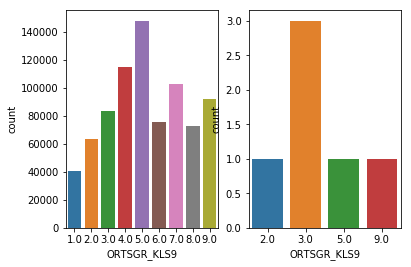

In [118]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# We write a function that plot, given a column name, the distribution of the missing values for the two subsets

def compare(data, column, split_threshold):
    
    '''
    column : column of dataframe whose distribution chart we want to visualize
    split_threshold : the threshold of missing values, encoded as NaN, to split the dataset into two groups of observations
    
    '''
    # Creating gorups depending on threshold user has input
    group_1 = (pd.isnull(data).sum(axis=1) <=split_threshold)
    group_2 = (pd.isnull(data).sum(axis=1) > split_threshold)
    
    # Splitting the dataset accordingly
    data_group_1 = data.loc[group_1,:]
    data_group_2 = data.loc[group_2,:]
    
    # Plot distribution of values for column chosen by the user, for the two groups separately
    fig = plt.figure()
    
    ax1 = fig.add_subplot(121)
    sns.countplot(x=col, data=data_group_1)
    
    ax1 = fig.add_subplot(122)
    sns.countplot(x=col, data=data_group_2)

# First we draw a random sample of 5 columns from our cleaned dataset (cleaned in terms of columns removed)
col_sample = list(np.random.choice(list(azdias_clean.columns),5))

for col in col_sample:
    try:
        compare(azdias_clean, col, 30)
    except ValueError:
        continue


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer**

As can be seen by the 5 subplots above, when choosing the threshold value of 30, the shape of the distribution for most features seem to be the same. Hence it is reasonable to drop these rows.

In [119]:
# We drop the rows belonging to the group with missing values

azdias_clean = azdias_clean.loc[rows_group_1,:]

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [120]:
# How many features are there of each data type?

# In order to see how many feature of a specific type we have we group by type and then use count()
feat_info.groupby(["type"]).count()['attribute']

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [121]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Firstly we create a list of all categorical variables from the feat_info dataframe
cat_list = list(feat_info[(feat_info.type == "categorical")]["attribute"])
print(cat_list)

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [122]:
# Now we use these list to see how many unique values each categorical feature has
# therefeore classigying them as either binary, multi-level, and identifying the non-numeric binary

cat_binary = []
cat_non_num = []
cat_multi = []

for col in list(azdias_clean.columns):
    if col in cat_list:
        if type(azdias_clean[col][1]) == str:
            cat_non_num.append(col)
        else:
            n = azdias_clean[col].nunique()
            if n == 2:
                cat_binary.append(col)
            else:
                cat_multi.append(col)

In [123]:
# We examine each categorical feeature  list
print(cat_binary)
print(cat_non_num)
print(cat_multi)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP']


In [124]:
# We investigate further the non numeric categorical feeatures and we note that there are two non numeric
# features we need to deal with:

# "OST_WEST_KZ"
# "CAMEO_DEU_2015"

# However gien that the information of CAMEO_DEU is just a more precise breakdown of CAMEO_DEUG, this feature is highly redundant
# and we decide to drop it

# We re-encode this in the cell below
azdias_clean[cat_non_num].head()

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,W,8,8A
2,W,4,4C
3,W,2,2A
4,W,6,6B
5,W,8,8C


In [125]:
# Re-encode categorical variable(s) to be kept in the analysis.
# We re-encode "OST_WEST_KZ" as follows:
# 0 if value is "O"
# 1 if value is "W"

#azdias_clean["OST_WEST_KZ"] = azdias_clean["OST_WEST_KZ"].apply(lambda x: 1 if x == "W" else 0 if x == "O" else x)
azdias_clean["OST_WEST_KZ"] = azdias_clean.loc[:,"OST_WEST_KZ"].apply(lambda x: 1 if x == "W" else 0 if x == "O" else x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [126]:
# Re-Econding CAMEO_DEUG_2015 and dropping CAMEO_DEU_2015
# CAMEO_DEUG_2015 as a string data type, while we want int. CAMEO DEU 2015 contains the same infomration as
# CAMEO_DEUG, but with more granularity and we hence decide to drop it

cameo_map = {'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8,
                  '9':9}

azdias_clean["CAMEO_DEUG_2015"] = azdias_clean.loc[:,"CAMEO_DEUG_2015"].apply(lambda x: x if pd.isnull(x) == True else cameo_map[x])
azdias_clean.drop(["CAMEO_DEU_2015"], axis=1, inplace=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [127]:
# Finally we drop the multi class categorical features

# We first create a copy of the columns to keep
col_to_keep = list(set(list(azdias_clean.columns)) - set(cat_multi))
azdias_clean = azdias_clean.loc[:,col_to_keep]

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**

In conducting the analysis I separated the categorical features into three set:
- Binary features
- Non numeric categorical features
- Multi categories features

The decision has been to keep the binary features, re-encode the non numeric ones and drop the multi categories. The re-encoding mechanism has been defined in the code cell above.

Other decisions at each step have been duly commented in each appropriate code cell.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [128]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Engineering the decades variable
# In order to perform this engineering feature step we simply create a dictionary that maps each observation label
# to the resepctive ordinal group: in this case the decade

decades_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4,
                  9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

azdias_clean["DECADE"] = azdias_clean.loc[:,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: x if np.isnan(x) == True else decades_map[x])


In [129]:
# Engineering the binary feature movement
# In order to perform this engineering feature step we simply create a dictionary that maps each observation label
# to the resepctive movement, encoded here as a binary (1/2)


movement_map = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1,
                  9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}


azdias_clean["MOVEMENT"] = azdias_clean.loc[:,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: x if np.isnan(x) == True else movement_map[x])


In [130]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# As can be seen from the data_dictionary this feature contained two sub macro groups:
# 1) Household wealth type (Wealthy / Prosperous / Comfortable / Less Affluent / Poorer) - encoded as 5,4,3,2,1
# 2) Housefold age type (Pre-family / Young couples / Avg. families / Older families / Elderly in retirement )
# encoded as 1, 2, 3, 4, 5 

# We start by creating a mapping suitable for the first class (HOUSEHOLD_WEALTH)

wealth_map = {'11':5, '12':5, '13':5, '14':5, '15':5, '21':4, '22':4, '23':4,
                  '24':4, '25':4, '31':3, '32':3, '33':3, '34':3, '35':3,
                     '41':2, '42':2, '43':2, '44':2, '45':2, '51':1, '52':1, '53':1, '54':1, '55':1}


azdias_clean["HOUSEHOLD_WEALTH"] = azdias_clean.loc[:,"CAMEO_INTL_2015"].apply(lambda x: x if pd.isnull(x) == True else wealth_map[x])


In [131]:
# We know engineer the secnod feature, with the same mapping methodology as before, but by changing values of the dictionary

age_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3,
                  '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5,
                     '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_clean["HOUSEHOLD_AGE"] = azdias_clean.loc[:,"CAMEO_INTL_2015"].apply(lambda x: x if pd.isnull(x) == True else age_map[x])

In [132]:
# Finally drop all the mixed features since we don't need them anymore

mixed_feat_list = list(feat_info[feat_info.type == 'mixed']['attribute'])
col_to_keep_2 = list(set(list(azdias_clean.columns)) - set(mixed_feat_list))
azdias_clean = azdias_clean.loc[:,col_to_keep_2]


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**

We have engineered the two suggested mixed type features, whilst dropped the remaining ones. Detail of how engineering has been performed is provided in the appropriate code cells.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [133]:
# We take a quick look at our resulting dataset azdias.clean making sure the previous steps have been handled correctly
# A useful attribute of a Pandas dataframe is dtypes which lets us check, for each column what the data types are.

# In our case we are interested in making sure, these are only numeric (int64 / float64)
# In order to test that we create a logical expression, and tehn calculate teh % (via the mean), making sure is 1
# i.e. 100% of the columns are numeric

((azdias_clean.dtypes == 'float64') | (azdias_clean.dtypes == 'int64')).mean()

1.0

In [134]:
# We also take a look at the first few rows
azdias_clean.head()

,ARBEIT,FINANZ_UNAUFFAELLIGER,KBA05_ANTG3,HOUSEHOLD_AGE,CAMEO_DEUG_2015,SEMIO_KAEM,SEMIO_ERL,ALTERSKATEGORIE_GROB,KKK,EWDICHTE,...,KBA05_ANTG4,KBA05_GBZ,FINANZ_MINIMALIST,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,MOVEMENT,SEMIO_REL,SEMIO_KULT,FINANZ_ANLEGER,OST_WEST_KZ
1,3.0,4,0.0,1.0,8.0,4,2,1.0,2.0,3.0,...,2.0,1.0,1,6.0,9.0,1.0,4,3,5,1
2,3.0,3,1.0,4.0,4.0,7,6,3.0,2.0,4.0,...,0.0,3.0,1,4.0,9.0,2.0,3,3,2,1
3,2.0,1,0.0,2.0,2.0,5,7,4.0,NaN,2.0,...,0.0,4.0,4,1.0,9.0,1.0,2,4,2,1
4,4.0,3,1.0,3.0,6.0,2,4,3.0,3.0,5.0,...,0.0,3.0,4,5.0,9.0,1.0,4,6,1,1
5,2.0,2,0.0,4.0,8.0,4,2,1.0,4.0,2.0,...,0.0,4.0,3,5.0,9.0,1.0,7,5,2,1


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [135]:
def clean_data(df=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # STEP 1 - Converting missing_unknown values into NaN thanks to the global defined before feat_info
    
    for col in list(df.columns):
        for unknown_missing_list in feat_info[feat_info.attribute == col]["missing_or_unknown_list"]:
            if unknown_missing_list != [""]:
                for value in unknown_missing_list:
                    try:
                        num_val = float(value)
                        df[col] = df[col].replace(to_replace={num_val:np.nan})
                    except ValueError:
                        df[col] = df[col].replace(to_replace={value:np.nan})
    
    
    # STEP 2 - Removing Columns where the % of missing values is too high 
    # To be consistent with prior steps, the columns removed will be the same chosen for the whole demographic dataset
    # The list of columns to remove is in the global "removed"
    # For the same reasoning as above, rows are not removed
    
    df.drop(removed, axis = 1, inplace=True)
     
    # STEP 3 - Dealing with Categorical data:
    # Categorical data: keep binary, re-encode mixed, drop multi-class
    
    df["OST_WEST_KZ"] = df.loc[:,"OST_WEST_KZ"].apply(lambda x: 1 if x == "W" else 0 if x == "O" else x)
    df["CAMEO_DEUG_2015"] = df.loc[:,"CAMEO_DEUG_2015"].apply(lambda x: x if pd.isnull(x) == True else cameo_map[x])
    df.drop(["CAMEO_DEU_2015"], axis=1, inplace=True)
    df = df.loc[:,col_to_keep]
    
    # STEP 4 - Dealing with Mixed data:
    # Re-encoding of PRAEGENDE_JUGENDJAHRE / CAMEO_INTL_2015 , drop of all others
    df["DECADE"] = df.loc[:,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: x if np.isnan(x) == True else decades_map[x])
    df["MOVEMENT"] = df.loc[:,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: x if np.isnan(x) == True else movement_map[x])
    df["HOUSEHOLD_WEALTH"] = df.loc[:,"CAMEO_INTL_2015"].apply(lambda x: x if pd.isnull(x) == True else wealth_map[x])
    df["HOUSEHOLD_AGE"] = df.loc[:,"CAMEO_INTL_2015"].apply(lambda x: x if pd.isnull(x) == True else age_map[x])
    
    df = df.loc[:,col_to_keep_2]
    
    # STEP 5 - Dividing the dataframe into groups depending on whether rows have more than 30 missing values, and drop the group
    
    rows_group_keep = (pd.isnull(df).sum(axis=1) <=30)
    df = df.loc[rows_group_keep,:]
    
    # Return the cleaned dataframe.
    return df
 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [136]:
# We go ahead with imputation of the NaN values using as strategy the mode of each feature, i.e. the most recurring value

from sklearn.preprocessing import Imputer
imp= Imputer(missing_values='NaN', strategy='most_frequent')

azdias_imputed= pd.DataFrame(data=imp.fit_transform(azdias_clean),index=azdias_clean.index, columns=azdias_clean.columns)

In [137]:
# Apply feature scaling to the general population demographics data.

# We use Scikit-learnn StandardScaler in order to scale the population demographics data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_fit = scaler.fit_transform(azdias_imputed)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**Answer**

Given the large presence of missing values, simply droppning NaN would have been too expensive as that means we would have lost a significant amount of observations which might be valuable. Hence we do imputation where the missing values are replace with the mode, the most frequen value in each feature.

Once sure the data was cleaned, we fit a Standard Scaler from Scikit-learn to the general demographics data

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [138]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

# Initializing PCA without speciying any parameter and then fitting to the dataset
pca = PCA()
pca.fit(azdias_fit)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

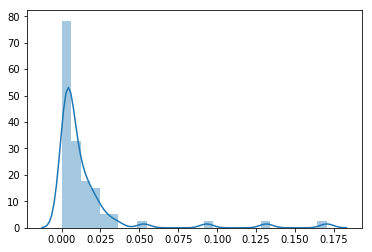

In [139]:
# Investigate the variance accounted for by each principal component.

# In order to investigate the variance explained by each principal component we use the attribute of the fitted mode
# explained_variance_ratio. We use this attribute to plot both an histogram, as well as a line representing the cumulative sum

sns.distplot(pca.explained_variance_ratio_)

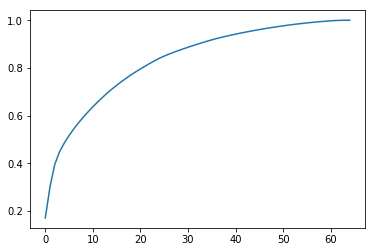

In [140]:
# Plotting the cumulative sum
plt.plot(pca.explained_variance_ratio_.cumsum())


In [141]:
# The plo above shows that with 10 components we ar already able to explain more than half of the variance.
# With 21 components we are above 80%. We print the 10 and 21 element of the cum sum to confirma

print("After 10 components {0}% of the variance is explained".format(100 * round(pca.explained_variance_ratio_.cumsum()[9],4)))
print("After 21 components {0}% of the variance is explained".format(100 * round(pca.explained_variance_ratio_.cumsum()[20],4)))

After 10 components 61.58% of the variance is explained
After 21 components 79.55% of the variance is explained


In [142]:
# Re-apply PCA to the data while selecting for number of components to retain.

# We go ahead with 21 components as that's a sensible reduction from the 60+ predictors of the cleaned dataset. 
pca = PCA(n_components = 21)
pca.fit(azdias_fit)


PCA(copy=True, iterated_power='auto', n_components=21, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Answer**

As documented above in the code cells, frist of all we have applied a standard scaler to bring the features down to a zero mean and unit variance. Subsequently we have calculated all the PCAs and looked for a pattern in the cumulative sum plot. 

Although it is not easy at a first glimpse to find the right elbow point we see that after 21 components, 80% of the variance is explained. This is sensible as we're efectively getting 4/5 of the variance with only 1/3 or less than the original predictors. This seems a good compromise.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [143]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def component_analysis(component = 0):
    
    pc = pca.components_[component]
    map_pc_weights = {value[0]:value[1] for value in zip(list(azdias_clean.columns), list(pc))}
    pc_weights = pd.Series(map_pc_weights)
    return pc_weights.sort_values(ascending=False)

In [144]:
# 1st PRINCIPAL COMPONENT

first_pc_weights = component_analysis(0)

# The most interesting values are those at the beginning and end of the series we return the first and last 5
print(first_pc_weights.head(5))
print("*************************")
print(first_pc_weights.tail(5))

PLZ8_ANTG3            0.224236
CAMEO_DEUG_2015       0.217954
PLZ8_ANTG4            0.215624
HH_EINKOMMEN_SCORE    0.204089
ORTSGR_KLS9           0.193758
dtype: float64
*************************
KBA05_ANTG1        -0.213363
HOUSEHOLD_WEALTH   -0.213997
KBA05_GBZ          -0.214945
MOBI_REGIO         -0.223437
PLZ8_ANTG1         -0.225263
dtype: float64


In [145]:
# 2nd PRINCIPAL COMPONENT

second_pc_weights = component_analysis(1)

# The most interesting values are those at the beginning and end of the series we return the first and last 5
print(second_pc_weights.head(5))
print("*************************")
print(second_pc_weights.tail(5))

ALTERSKATEGORIE_GROB    0.264632
FINANZ_VORSORGER        0.237172
SEMIO_ERL               0.233936
SEMIO_LUST              0.185006
RETOURTYP_BK_S          0.162997
dtype: float64
*************************
SEMIO_PFLICHT   -0.233382
SEMIO_TRADV     -0.234591
FINANZ_SPARER   -0.241793
DECADE          -0.245956
SEMIO_REL       -0.260566
dtype: float64


In [146]:
# 2rd PRINCIPAL COMPONENT

third_pc_weights = component_analysis(2)

# The most interesting values are those at the beginning and end of the series we return the first and last 5
print(third_pc_weights.head(5))
print("*************************")
print(third_pc_weights.tail(5))

SEMIO_VERT           0.345620
SEMIO_SOZ            0.261864
SEMIO_FAM            0.249002
SEMIO_KULT           0.234531
FINANZ_MINIMALIST    0.157094
dtype: float64
*************************
SEMIO_RAT    -0.218018
SEMIO_KRIT   -0.276118
SEMIO_DOM    -0.314225
SEMIO_KAEM   -0.336692
ANREDE_KZ    -0.368113
dtype: float64


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Answer**

*1st Principal Component:*

For the first principal component it seems that micro and macro cell features are what determine the nature of the component. In particular the component has large positive weights associated with features representing the dominant (lower than avg, avg, greater than avg) type (in terms of household components) family houses in the region. This is confirmed by the fact that PLZ8_ANTG1 (%. of 1-2 families in the region) has a large negative weight. Also worth to note KBA05_ANTG1 has the largest negative weight (this feature is the % of 1-2 family houses in the micro cell). This reinforces the analysis above.

*2nd Principal Component:*

The second principal component has large weights (in absolute values) especially for the SEMIO and FINANZ features. So this component seems to represent individuals in terms of their personalities (SEMIO) and finances (FINANZ). Large positive weights are given to sensual-minded and event-oriented while large negative weight is given to dutiful and religious type of personality. Interestingly it seems that these two personality clusters are associated with different behaviour when it comes to spending vs. saving. In fact large weight is given to FINANZ_VORSORGER which is classified as "prepared" type of financial person, while large negative sign is given to SPARER (money saver). This component seems to discriminate between two very different type of persons (more social, event oriented people who also tend to spend more vs. more dutiful, religious type of person who are more careful with their finances)

*3nd Principal Component:*

The third component is dominated by the category SEMIO, hence expressing differences in different personalities clusters. On the one side positive weights is given to social and family type of people who are also dreamful. Large negative weight is given to people who are more critical minded, rational and more dominant. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [147]:
# First of all we get the transformed data
azdias_transformed = pca.transform(azdias_fit)


In [148]:
# We confirm the transformed the dataset is in the shape we expect (# of data points * # number of components)
azdias_transformed.shape

(798067, 21)

In [149]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

clusters = list(range(2,11))
avg_distance = []

# run k-means clustering on the data and...
for cluster in clusters:
    model = KMeans(n_clusters = cluster)
    model.fit(azdias_transformed)

# compute the average within-cluster distances.
# looking at the KMeans algorithm in Scikit learn, this minimizes the inertia, defined as intra cluster varation
# wehere variation is point wise sum of square distance. However if we look at the source code for inertia()
# and score() we see that this returns the opposite (-1*) the inertia, as the score always needs to be interpreted
# in terms of the larger the better. In our case therefore we invert such operations by taking as our distance
# the negative of the score
    avg_distance.append(-model.score(azdias_transformed))

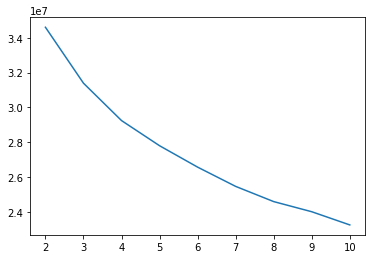

In [150]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# After fitting the K-means model for each cluster we plot the intracluster variation together with the number of clusters
# to decide an appropriate number to use in the analysis

plt.plot(clusters,avg_distance)

In [151]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Given that the intracluster variation setadily decreases we go with 10 as a number of clusters

model_10 = KMeans(n_clusters = 10)
model_10.fit(azdias_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Answer**

Running the model from two to 10 clusters we don't see any particular elbow shape or flattening, so we give with the maximum number of clusters we run, 10.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [152]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ";")

In [153]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# STEP 1 - Cleaning the data with the clean_data() function

customers_clean = clean_data(customers)
customers_imputed =imp.transform(customers_clean)
customers_scaled = scaler.transform(customers_imputed)

# STEP 2  - Transforming the data with the 21 principal components
customers_transformed = pca.transform(customers_scaled)

In [154]:
# STEP 3 - Obtainin Cluster predictions for the customer data based on the model previously fitted

cluster_pred = model_10.predict(customers_transformed)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [155]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

proportion_customers = []

for cluster in list(range(1,10)):
    proportion_customers.append((cluster_pred == cluster).mean())


In [156]:
proportion_customers

[0.019146370532396696,
 0.093341185378370425,
 0.46978364811621026,
 0.0097519595058820231,
 0.042793645452123559,
 0.12681052734895329,
 0.0096818519609080337,
 0.17837462667732301,
 0.019987661072084578]

In [157]:
# We calculate the proportions for the general dataset

general_pred = model_10.predict(azdias_transformed)

In [158]:
proportion_general = []

for cluster in list(range(1,10)):
    proportion_general.append((general_pred == cluster).mean())


In [159]:
# We calculate the proportions for the general dataset

proportion_general

[0.11382878881096449,
 0.11665561913974641,
 0.15445570359380853,
 0.10379955567640312,
 0.063170134838303055,
 0.11680347639985114,
 0.084831223443645715,
 0.150283121592548,
 0.0042001486090766814]

Text(0.5,1,'CUSTOMER')

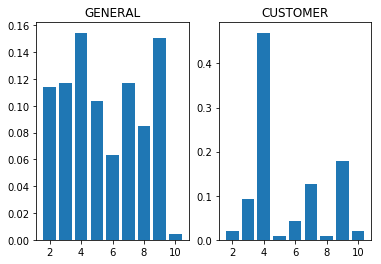

In [160]:
# Plotting the distribution of the proportions for the general and the customers data
clusters_x = list(range(2,11))

proportions_df = pd.DataFrame([proportion_general, proportion_customers], columns = clusters_x, index=["GENERAL", "CUSTOMER"])
proportions_df.head()

fig = plt.figure()
ax1 = fig.add_subplot(121)
plt.bar(clusters_x, proportions_df.loc['GENERAL',:])   
plt.title("GENERAL")
ax1 = fig.add_subplot(122)
plt.bar(clusters_x, proportions_df.loc['CUSTOMER',:])
plt.title("CUSTOMER")

In [161]:
# The barplot gives a hint into which categories are over/under represented. To understand which clusters are more or less
# over or under represented we create a difference row

differences = proportions_df.loc["GENERAL",:] - proportions_df.loc["CUSTOMER",:]
differences

2     0.094682
3     0.023314
4    -0.315328
5     0.094048
6     0.020376
7    -0.010007
8     0.075149
9    -0.028092
10   -0.015788
dtype: float64

In [162]:
# We can see that cluster number 4 is the most under represented
# Cluster 2 and 5 insntead are the most over represented. 

# In the analysis below we there fore investigate these two clusters.

In [166]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# INVESTIGATING CLUSTER 4 (SEE ABOVE VECTOR OF DIFFERENCES)
cluster_4 = model_10.cluster_centers_[2]
cluster_4
# In terms of Principal components, this cluster seems to be focused on the second principal component,
# whilst strongly different from component 1 and 3. 
# A possible interpretation of this is provided in the cell below.

array([ 1.07806639,  3.68568713, -1.50578399, -0.30894664, -0.28473491,
       -0.69908097, -0.03101901, -0.43577144,  0.17646924, -0.07842971,
       -0.06093538, -0.07161768,  0.21909553,  0.09606369, -0.12852696,
       -0.01499411, -0.00689635, -0.04195315,  0.07116279, -0.06869809,
       -0.07457698])

In [165]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# INVESTIGATING CLUSTER 2 (SEE ABOVE VECTOR OF DIFFERENCES)
cluster_2 = model_10.cluster_centers_[0]
cluster_2
# A possible interpretation of this is provided in the cell below.

array([ -1.24881273e+00,  -4.38142102e+00,   1.78609071e+00,
        -9.88928161e-02,  -5.14942986e-02,   1.41607398e-01,
         8.77468314e-02,  -9.02894598e-02,   1.83319073e-01,
        -1.80393164e-01,  -2.90901839e-01,   2.00980697e-01,
         1.96456271e-01,  -7.36724795e-03,  -1.53096806e-02,
        -5.68753186e-02,   8.30085876e-03,   1.16794473e-01,
        -1.06584106e-01,  -3.41794618e-02,   4.81783761e-04])

In [164]:
# INVESTIGATING CLUSTER 5 (SEE ABOVE VECTOR OF DIFFERENCES)
cluster_5 = model_10.cluster_centers_[3]
cluster_5
# A possible interpretation of this is provided in the cell below.

array([ -3.58726128e+00,   2.12384313e-02,   2.22112331e+00,
        -2.24681863e-02,   1.41375733e-01,   2.74619250e-02,
         9.95312535e-02,   2.40937250e-01,  -5.68003806e-02,
        -4.47668301e-02,   8.01341204e-02,  -1.67805718e-01,
        -9.66880928e-02,  -8.04555383e-02,   9.87260540e-02,
        -4.26437817e-02,   8.71275006e-04,  -6.01670336e-02,
        -6.08715539e-03,   3.08321744e-03,   3.09779823e-02])

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Answer**

From running this cluster analysis, we can see that the customers dataset has some differences (in terms of to what groups/clusters, identified examining the whole demographic dataset, customers belong to). In particular it seems that Cluster 4 is the most under represented whilst Cluster 2 and 5 is the most over represented.


The over represented clusters are cluster 2 and cluster 5. If we take a look at these two clusters we see that whilst they have a positive weight for the third component they have a negative weight for the first. As for the second component the weight is positive in one instance whilst negative in an other. From our original principal component interpretation, remember that the third component represented the difference in family type and dreamful peopole vs. critically minded and rational people. So it looks as if the company is targeting more these type (dreamful) of individuals.


Cluster 4, which is under represented has a large negative weight for Component 2. Component 2 represents those type of individuals who are more social type of people and who are also not big savers. Having a negative weight for this component might mean the company is trying to target customers with greater savings.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.